In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm #color maps

import nltk
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk import bigrams
from nltk.lm.preprocessing import pad_both_ends

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.feature_extraction import text # to modify stop words

from collections import defaultdict, Counter

## Read csv and create additional columns:

In [2]:
# read csv making sure Answer column is a string because of "NULL" answers
df = pd.read_csv("nick-xword-big.csv",converters={'Answer' : str, 'Hint' : str})

df

,Year,Month,Day,Weekday,Direction,Line,Hint,Answer,Author,Editor,PuzTitle,PuzClue,NumRows,NumCols,NumWords,NumBlocks,MissingLetters
0,2020,12,31,Thursday,Across,1,N.B.A. stat,PPG,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN
1,2020,12,31,Thursday,Across,4,Number of stripes on la bandera mexicana,TRES,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN
2,2020,12,31,Thursday,Across,8,Relay; e.g.,EVENT,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN
3,2020,12,31,Thursday,Across,13,"Oscar-winning actor for ""Moonlight"" and ""Green...",ALI,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN
4,2020,12,31,Thursday,Across,14,Chew (out),REAM,David J. Kahn,Will Shortz,"New York Times, Thursday, December 31, 2020",Local economy makeup ... or a hint to this puz...,15,15,70,40,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801879,1994,1,1,Saturday,Down,43,Over,ENDED,Manny Nosowsky,Will Shortz,"New York Times, Saturday, January 1, 1994","When the ghost appears in ""Hamlet""",15,15,66,38,JQXZ
801880,1994,1,1,Saturday,Down,46,Sprinkle site,CONE,Manny Nosowsky,Will Shortz,"New York Times, Saturday, January 1, 1994","When the ghost appears in ""Hamlet""",15,15,66,38,JQXZ
801881,1994,1,1,Saturday,Down,47,"""___ it"" (conversation closer)",SOBE,Manny Nosowsky,Will Shortz,"New York Times, Saturday, January 1, 1994","When the ghost appears in ""Hamlet""",15,15,66,38,JQXZ
801882,1994,1,1,Saturday,Down,50,Frost relative,DEW,Manny Nosowsky,Will Shortz,"New York Times, Saturday, January 1, 1994","When the ghost appears in ""Hamlet""",15,15,66,38,JQXZ


In [3]:
# Create BlockDensity column
df['BlockDensity'] = (df['NumBlocks'] / (df['NumRows'] * df['NumCols']))*100

In [4]:
#Make a column for answer length
df['AnswerLength'] = df['Answer'].str.len()

In [5]:
# make a single date column (this should also serve a unique puzzle identifier)
df['Date'] = df['Year'].astype(str) +'-'+ df['Month'].astype(str) +'-'+ df['Day'].astype(str)
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df_validate = df.groupby(['Date','NumWords'])['Answer'].count().reset_index().copy()

df_validate[df_validate.Answer != df_validate.NumWords]

,Date,NumWords,Answer
416,1995-02-22,72,16
445,1995-03-25,72,1
458,1995-04-08,72,5
477,1995-04-29,72,7
484,1995-05-06,66,7
...,...,...,...
9436,2020-02-14,72,68
9557,2020-06-14,140,43
9574,2020-07-01,75,57
9612,2020-08-08,70,25


### Basic stats:

In [7]:
# Puzzle count by author
df.groupby(['Author'])['PuzTitle'].nunique().sort_values(ascending=False).reset_index().head(10)

,Author,PuzTitle
0,Manny Nosowsky,224
1,Patrick Berry,214
2,Elizabeth C. Gorski,207
3,David J. Kahn,167
4,Rich Norris,159
5,Brendan Emmett Quigley,150
6,Joe DiPietro,126
7,Alan Arbesfeld,120
8,Randolph Ross,105
9,Peter A. Collins,99


In [8]:
#Average number of blocks by weekday
df.groupby(['Weekday'])['NumBlocks'].mean().sort_values(ascending=False).reset_index()

,Weekday,NumBlocks
0,Sunday,75.364446
1,Monday,37.537245
2,Wednesday,37.485311
3,Tuesday,37.417742
4,Thursday,37.013904
5,Friday,31.464006
6,Saturday,30.743494


In [9]:
# top ten longest answers
df.sort_values(by='AnswerLength',ascending=False).head(10)[['Weekday','Hint','Answer','AnswerLength']]

,Weekday,Hint,Answer,AnswerLength
763707,Sunday,Word chain #1 (12 wds.; coming full circle),HOUSEPARTYLINEDRIVEWAYSIDEKICKBACKHANDOVERNIGH...,52
560325,Sunday,Cry heard shortly before 16-Down,TENNINEEIGHTSEVENSIXFIVEFOURTHREETWOONEITSTWOO...,50
363929,Sunday,Greeting from 74-Down,HOHOHOHOHOHOHOHOHOHOHOHOHOHOHOHOHOHOHOHOHO,42
143463,Thursday,-,CIRCULARREASONINGMAKESNOSENSEBECAUSE,36
473725,Sunday,Mock plea for civil language,STOPTHEPOUNDATPERCENTSTARANDCUSSING,35
193441,Thursday,Visual representation of this puzzle's theme,SPACESPACESPACESPACESPACESPACESPACE,35
163819,Thursday,Mouthful from a 1964 song,SUPERCALIFRAGILISTICEXPIALIDOCIOUS,34
460729,Thursday,Piano exercise for beginners,DOREMIFASOLLATIDOTILASOLFAMIREDO,32
481784,Sunday,Call for help,DOTDOTDOTDASHDASHDASHDOTDOTDOT,30
287031,Friday,Pro-Church of England position,ANTIDISESTABLISHMENTARIANISM,28


## block density

blocks = the black squares on the puzzle grid

In [10]:
# Get the average BlockDensity by day, and also all individual BlockDensity values for the plot later
block_data = df.groupby(['Weekday'])['BlockDensity'].agg([np.mean, np.std, list]).reset_index()
block_data

,Weekday,mean,std,list
0,Friday,13.969817,1.888206,"[14.222222222222221, 14.222222222222221, 14.22..."
1,Monday,16.666676,1.052465,"[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16...."
2,Saturday,13.645211,1.753924,"[12.88888888888889, 12.88888888888889, 12.8888..."
3,Sunday,16.796030,1.194783,"[17.233560090702948, 17.233560090702948, 17.23..."
4,Thursday,16.404469,1.443694,"[17.77777777777778, 17.77777777777778, 17.7777..."
5,Tuesday,16.600833,1.057248,"[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16...."
6,Wednesday,16.613964,1.178799,"[15.11111111111111, 15.11111111111111, 15.1111..."


In [11]:
# Sort by the mean
block_data.sort_values(by='std', ascending=True, inplace=True)

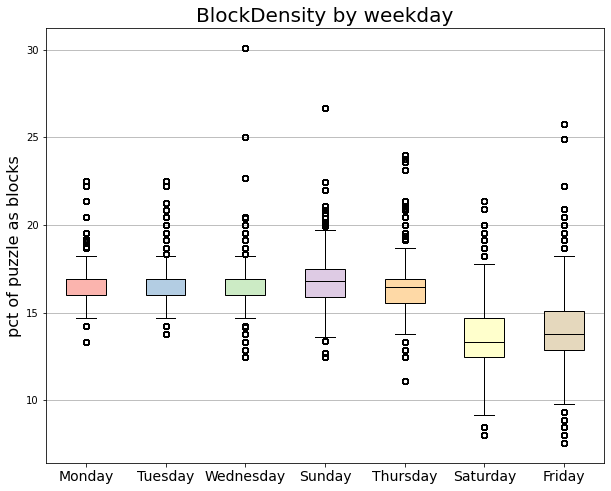

In [12]:
# plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
bplot = ax.boxplot(block_data['list'],patch_artist=True, medianprops=dict(color='black'))
ax.set_xticklabels(block_data['Weekday'].tolist(),fontsize=14)
ax.set_ylabel('pct of puzzle as blocks',fontsize=16)
ax.set_title('BlockDensity by weekday',fontsize=20)
ax.grid(True,axis='y')

cmap = cm.get_cmap('Pastel1')

for patch, color in zip(bplot['boxes'], cmap.colors):
    patch.set_facecolor(color)
#plt.savefig(fname="density")
plt.show()

## puzzle density over time

In [13]:
time_data = df.groupby(['Weekday','Year'])['BlockDensity'].mean().reset_index().copy()

time_data

,Weekday,Year,BlockDensity
0,Friday,1994,16.573682
1,Friday,1995,15.200780
2,Friday,1996,14.459082
3,Friday,1997,14.596993
4,Friday,1998,14.504471
...,...,...,...
184,Wednesday,2016,16.606938
185,Wednesday,2017,16.689204
186,Wednesday,2018,16.889263
187,Wednesday,2019,16.931687


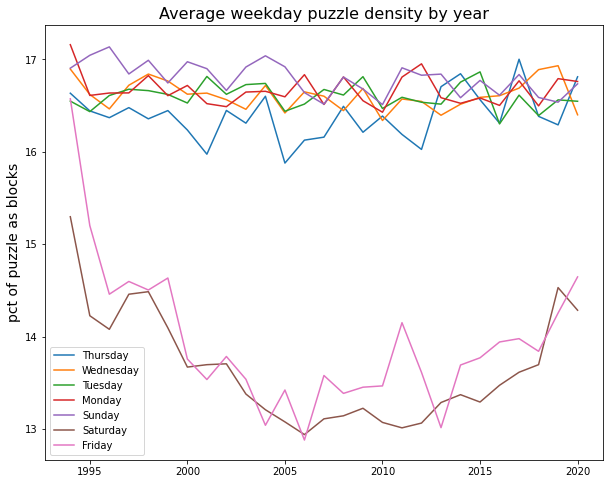

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

for day in df.Weekday.unique().tolist():
    ax.plot(time_data['Year'].loc[time_data['Weekday'] == day],time_data['BlockDensity'].loc[time_data['Weekday'] == day],label=day)


ax.set_ylabel('pct of puzzle as blocks',fontsize=14)
ax.set_title('Average weekday puzzle density by year',fontsize=16)
ax.legend()

plt.show()

## average answer length

In [15]:
len_data = df.groupby('Weekday')['AnswerLength'].agg([np.mean, list]).reset_index().copy()
len_data.sort_values(by='mean', ascending=True, inplace=True)
len_data

,Weekday,mean,list
1,Monday,4.876887,"[4, 5, 4, 4, 5, 4, 4, 5, 4, 6, 8, 5, 5, 3, 3, ..."
5,Tuesday,4.896390,"[4, 4, 5, 4, 4, 5, 15, 3, 6, 4, 3, 7, 12, 4, 3..."
6,Wednesday,4.935521,"[4, 4, 5, 9, 5, 9, 5, 3, 11, 3, 3, 6, 4, 4, 4,..."
4,Thursday,5.109273,"[3, 4, 5, 3, 4, 6, 3, 4, 6, 10, 6, 8, 4, 6, 7,..."
3,Sunday,5.309589,"[5, 6, 4, 3, 5, 6, 4, 3, 12, 8, 4, 6, 4, 4, 5,..."
0,Friday,5.579388,"[5, 5, 3, 5, 5, 3, 5, 5, 3, 10, 4, 6, 7, 3, 4,..."
2,Saturday,5.652210,"[3, 4, 6, 8, 6, 8, 6, 10, 4, 4, 4, 4, 6, 3, 4,..."


In [16]:
# inspect short answers
df.loc[df['Answer'].str.len() < 2]

,Year,Month,Day,Weekday,Direction,Line,Hint,Answer,Author,Editor,PuzTitle,PuzClue,NumRows,NumCols,NumWords,NumBlocks,MissingLetters,BlockDensity,AnswerLength,Date
5830,2020,10,22,Thursday,Across,21,What's theorized to have preceded the Big Bang,,Sid Sivakumar,Will Shortz,"New York Times, Thursday, October 22, 2020",Keeps going despite fatigue ... or a hint to t...,15,15,78,40,NaN,17.777778,0,2020-10-22
5837,2020,10,22,Thursday,Across,36,What polar opposites have in common,,Sid Sivakumar,Will Shortz,"New York Times, Thursday, October 22, 2020",Keeps going despite fatigue ... or a hint to t...,15,15,78,40,NaN,17.777778,0,2020-10-22
5847,2020,10,22,Thursday,Across,50,What's uttered by a mime,,Sid Sivakumar,Will Shortz,"New York Times, Thursday, October 22, 2020",Keeps going despite fatigue ... or a hint to t...,15,15,78,40,NaN,17.777778,0,2020-10-22
210363,2014,1,9,Thursday,Across,65,___-square,T,Caleb Emmons,Will Shortz,"New York Times, Thursday, January 9, 2014","Lucy ___, title character in Sir Walter Scott'...",15,15,76,40,KWX,17.777778,1,2014-01-09
216212,2013,10,31,Thursday,Across,65,64-Across; in 23-Down,,David Kwong,Will Shortz,"New York Times, Thursday, October 31, 2013",Nickname for a 2012 presidential candidate,15,15,78,36,NaN,16.000000,0,2013-10-31


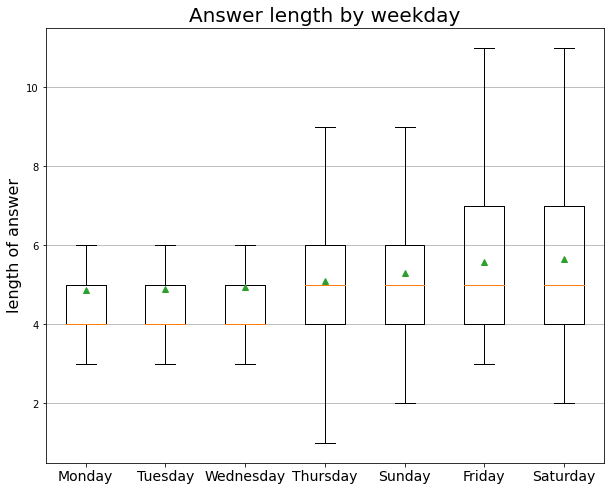

In [17]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(10, 8)

ax1.boxplot(len_data['list'], showfliers=False, showmeans=True)
ax1.set_xticklabels(len_data['Weekday'].tolist(),fontsize=14)
ax1.set_ylabel('length of answer',fontsize=16)
ax1.set_title('Answer length by weekday',fontsize=20)
ax1.grid(True,axis='y')

plt.show()

## scikit learn tfidf

### tfidf for answers by day of week

In [18]:
# concatenate all answers together in a single cell
# only year 2000 to keep things managable while testing
#df_ans = df.loc[df['Year'] == 2000].groupby(['Weekday','Date'])['Answer'].apply(lambda x: " ".join(x)).reset_index().copy()

In [19]:
# concatenate all answers together in a single cell
# only year 2000 to keep things managable while testing
df_ans = df.groupby(['Weekday','Date'])['Answer'].apply(lambda x: " ".join(x)).reset_index().copy()

In [20]:
ans_vectorizer = TfidfVectorizer() 

In [21]:
ans_tfidf = ans_vectorizer.fit_transform(df_ans['Answer'])

In [22]:
ans_tfidf.shape

(9757, 114694)

In [23]:
# reduce tfidf vector space to 2 dimensions with PCA
#pca = PCA(n_components=2)
#reduced = pca.fit_transform(ans_tfidf.todense())

MemoryError: Unable to allocate 8.34 GiB for an array with shape (9757, 114694) and data type float64

In [ ]:
# transpose the reduced space for plotting
t = reduced.transpose()

# list of weekday labeles, with indices preserved
day_labels = df_ans['Weekday'].tolist()
#day_idx = {}

fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("tfidf scores for puzzle ANSWERS by day of week, 2000",fontsize=20)
for day in list(set(day_labels)):
    day_indices = [i for i, x in enumerate(day_labels) if x == day]
    ax.scatter(t[0][day_indices], t[1][day_indices],label=day)

plt.legend()
plt.show()

### tfidf for hints by day of week

In [ ]:
df_hints = df.loc[df['Year'] == 2000].groupby(['Weekday','Date'])['Hint'].apply(lambda x: " ".join(x)).reset_index().copy()

In [ ]:

hint_vectorizer = TfidfVectorizer(stop_words='english') 
ans_tfidf = hint_vectorizer.fit_transform(df_hints['Hint'])
pca = PCA(n_components=2)

reduced = pca.fit_transform(ans_tfidf.todense())




In [ ]:
t = reduced.transpose()
day_labels = df_ans['Weekday'].tolist()

fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("tfidf scores for puzzle HINTS by day of week, 2000",fontsize=20)
for day in list(set(day_labels)):
    day_indices = [i for i, x in enumerate(day_labels) if x == day]
    ax.scatter(t[0][day_indices], t[1][day_indices],label=day)

plt.legend()
plt.show()

### tfidf for hints by year

In [ ]:
df_years = df.loc[df['Weekday'] == 'Sunday'].groupby(['Year','Date'])['Hint'].apply(lambda x: " ".join(x)).reset_index().copy()

In [ ]:
# add 'fill in the blank' string as stop word (but we could also keep this!)
nyt_stop = ['___']

stop_words = text.ENGLISH_STOP_WORDS.union(nyt_stop)

year_vectorizer = TfidfVectorizer(use_idf=True, stop_words=stop_words, smooth_idf=True) 

yr_tfidf = year_vectorizer.fit_transform(df_years['Hint'])
pca = PCA(n_components=2)

reduced = pca.fit_transform(yr_tfidf.todense())
t = reduced.transpose()
labels = df_years['Year'].tolist()


In [ ]:
t[1][1000]

In [ ]:
df_years['Date'].iloc[1000]

In [ ]:
potentially_strange_puzzles = []
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("tfidf similarity between puzzle hints, Sunday",fontsize=20)
for yr in list(set(labels)):
    year_index = [i for i, x in enumerate(labels) if x == yr]
    x, y = t[0][year_index], t[1][year_index]
    ax.scatter(x, y, label=yr)
    # this loop only annotates those outlier points, eyeballing the coordinates
    for i in x:
        if i > 0.15:
            for j, yr_idx in zip(y,year_index):
                if j > 0.2:
                    ax.annotate(str(yr),(i,j),xytext=(0,8),textcoords='offset points')
                    potentially_strange_puzzles.append(df_years['Date'].iloc[yr_idx])

plt.legend()
plt.show()
print(f"Potentially strange puzzles: ")
for puzz in potentially_strange_puzzles:
      print(f"https://www.xwordinfo.com/Crossword?date={puzz.month}/{puzz.day}/{puzz.year}")

## finding answers unique to each puzzle

In [24]:
df_uniques = df.groupby(['Date'])['Answer'].apply(list).reset_index().copy()
df_uniques.sample(5)

,Date,Answer
3936,2004-11-18,"[DISTAL, TASSEL, EMPORIA, MORAINE, SPONGER, UN..."
9527,2020-05-15,"[LAICAL, CRIMES, IMNOTOK, UNPACK, LASTSTEP, TA..."
3583,2003-11-23,"[FLU, LOO, MGM, CRAW, BANG, DANSEUR, MOTOROLA,..."
7359,2014-06-04,"[THEE, ICBM, JACKO, SAWS, ROOM, ORGAN, KEEPHOU..."
5438,2009-03-01,"[HUSTLE, COAX, RSVP, NAST, ENTAIL, ANNE, EPEE,..."


In [25]:
ans_dict = defaultdict(list)

# build a dictionary with answers for keys and puzzles for values
for index, row in df_uniques.iterrows():
    for ans in row['Answer']:
        ans_dict[ans].append(index)

# find all keys mapped to only one puzzle
unique_ans = [hint for hint, pz in ans_dict.items() if len(pz) == 1]

# take the intersection of a puzzle's answers with the unique answer set (applied below)
def get_unique_clues(row):
    return list(set(row).intersection(set(unique_ans)))


In [26]:
# Adds a column that says how many other puzzles have this answer
df['OtherPuzAns'] = df['Answer'].apply(lambda x: len(ans_dict[x]))

In [27]:
# Group by day of week for answer rarity
df_rarity = df.groupby(['Weekday'])['OtherPuzAns'].agg([np.mean, np.std, list]).sort_values(by='mean',ascending=False).reset_index().copy()
df_rarity

,Weekday,mean,std,list
0,Monday,76.873460,85.218188,"[127, 19, 65, 98, 77, 172, 100, 174, 85, 9, 3,..."
1,Tuesday,72.982862,83.877517,"[42, 63, 21, 393, 39, 60, 1, 187, 1, 47, 133, ..."
2,Wednesday,70.639584,83.519225,"[10, 46, 16, 1, 20, 1, 122, 407, 4, 42, 113, 4..."
3,Thursday,64.277172,80.844734,"[4, 103, 83, 422, 98, 13, 148, 80, 9, 1, 7, 2,..."
4,Sunday,57.386888,76.109347,"[22, 2, 73, 39, 41, 17, 105, 301, 1, 3, 176, 1..."
5,Friday,50.585374,72.127368,"[45, 10, 24, 1, 25, 104, 49, 22, 209, 2, 170, ..."
6,Saturday,46.531497,69.392298,"[259, 169, 9, 2, 42, 1, 13, 2, 13, 59, 53, 54,..."


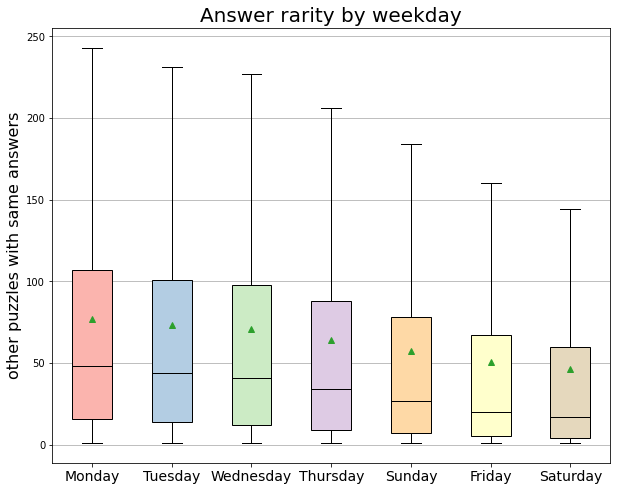

In [28]:
# plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
bplot = ax.boxplot(df_rarity['list'],patch_artist=True, medianprops=dict(color='black'), showfliers=False, showmeans=True)
ax.set_xticklabels(df_rarity['Weekday'].tolist(),fontsize=14)
ax.set_ylabel('other puzzles with same answers',fontsize=16)
ax.set_title('Answer rarity by weekday',fontsize=20)
ax.grid(True,axis='y')

cmap = cm.get_cmap('Pastel1')

for patch, color in zip(bplot['boxes'], cmap.colors):
    patch.set_facecolor(color)
#plt.savefig(fname="density")
plt.show()

In [29]:
# Column for a list of unique answers
df_uniques['UniqueClues'] = df_uniques['Answer'].apply(get_unique_clues)

In [30]:
# Column for the number of unique answers per puzzle
df_uniques['NumUniques'] = df_uniques['UniqueClues'].apply(len)

In [31]:
# Recreate the weekday column (oops)
df_uniques['Weekday'] = df['Date'].apply(lambda x: x.day_name())

In [32]:
# Inspect
df_uniques.sample(5)

,Date,Answer,UniqueClues,NumUniques,Weekday
9230,2019-07-22,"[CAP, DEER, DODGED, RIO, IDLE, ORIOLE, ESP, RU...","[PELICANSTATE, WHATSMYNAME, SKINNYDIPPER]",3,Thursday
8584,2017-10-13,"[DAMASK, SCARAB, IMALONE, ILLINI, GERANIUM, TO...","[MARKETWATCH, OPERAHOUSES, DIGITALDATA, PILOTS...",7,Friday
3645,2004-01-24,"[FRUSTRATING, SEASIDERESORT, STEVENSPIELBERG, ...","[GREENSALADS, TRACEELEMENTS, STABLEDOORS, SAFE...",10,Tuesday
7068,2013-08-17,"[ABLE, MSNBC, ABRA, NAAN, ILIED, MEAN, TYPEWRI...","[DELICIOUS, MECCAN, TYPEWRITERSTAND, SORRYFORT...",5,Tuesday
7647,2015-03-20,"[ENDSIT, ARROWS, BOOTLEG, RONNIE, BIGYEARS, EA...","[GIANTSLALOM, GRANDNEPHEW, BIGYEARS, COMPUTE, ...",5,Tuesday


In [33]:
unique_data = df_uniques.groupby('Weekday')['NumUniques'].agg([np.mean, list]).reset_index().copy()
unique_data.sort_values(by='mean', inplace=True)
unique_data

,Weekday,mean,list
4,Thursday,5.588976,"[2, 16, 2, 3, 2, 7, 5, 10, 14, 4, 1, 0, 2, 3, ..."
0,Friday,5.624579,"[8, 3, 8, 19, 5, 2, 5, 4, 7, 3, 9, 2, 5, 6, 5,..."
2,Saturday,5.681159,"[6, 12, 3, 4, 5, 2, 8, 0, 12, 1, 4, 4, 7, 8, 3..."
6,Wednesday,5.706843,"[5, 11, 2, 3, 8, 4, 9, 7, 8, 0, 5, 8, 5, 5, 6,..."
1,Monday,5.747320,"[6, 5, 13, 2, 1, 9, 6, 4, 5, 10, 3, 3, 3, 2, 6..."
3,Sunday,5.758311,"[11, 11, 2, 4, 2, 6, 8, 6, 11, 4, 1, 5, 6, 9, ..."
5,Tuesday,5.814985,"[9, 8, 9, 6, 9, 3, 2, 4, 2, 7, 4, 14, 4, 8, 5,..."


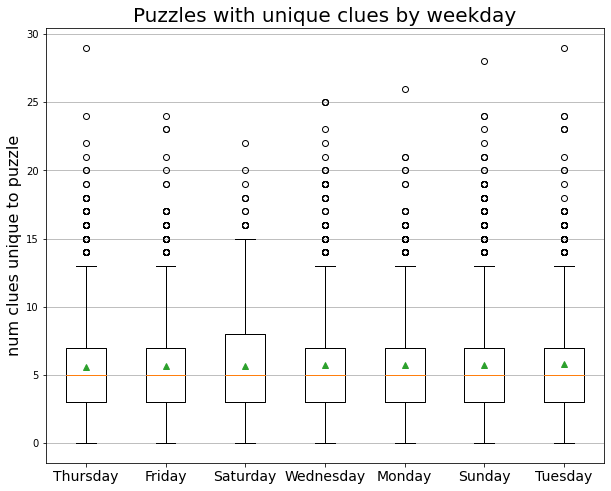

In [34]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(10, 8)

ax1.boxplot(unique_data['list'], showfliers=True, showmeans=True)
ax1.set_xticklabels(unique_data['Weekday'].tolist(),fontsize=14)
ax1.set_ylabel('num clues unique to puzzle',fontsize=16)
ax1.set_title('Puzzles with unique clues by weekday',fontsize=20)
ax1.grid(True,axis='y')

plt.show()

### character ngram language model

In [35]:
df_perplex = df.copy()

In [36]:
# make a single date column (this should also serve a unique puzzle identifier)
df_perplex['Date'] = df_perplex['Year'].astype(str) +'-'+ df_perplex['Month'].astype(str) +'-'+ df_perplex['Day'].astype(str)
df_perplex['Date'] = pd.to_datetime(df_perplex['Date'])

In [37]:
# drops rows with 0 length answers
df_perplex.drop(df_perplex.loc[df_perplex['Answer'] == ""].index, inplace=True)

In [38]:
answers = df_perplex['Answer'].tolist()

#answers

In [39]:
train, vocab = padded_everygram_pipeline(2, answers)
ans_lm = MLE(2)
ans_lm.fit(train, vocab)

In [40]:
ans_lm.entropy(bigrams(pad_both_ends("ANTIDISESTABLISHMENTARIANISM",n=2)))

3.7325228264858223

In [41]:
ans_lm.perplexity(bigrams(pad_both_ends("RAN",n=2)))

8.687486161264706

In [42]:
list(bigrams(pad_both_ends("RAN",n=2)))

[('<s>', 'R'), ('R', 'A'), ('A', 'N'), ('N', '</s>')]

In [43]:
df_perplex['AnsPerplexity'] = df_perplex['Answer'].apply(lambda x: ans_lm.perplexity(bigrams(pad_both_ends(x,n=2))))

In [44]:
df_perplex['AnsEntropy'] = df_perplex['Answer'].apply(lambda x: ans_lm.entropy(bigrams(pad_both_ends(x,n=2))))

In [45]:
perplex_data = df_perplex.groupby('Weekday')['AnsPerplexity'].agg([np.mean, np.std, list, np.amax]).reset_index().sort_values('mean').copy()
perplex_data

,Weekday,mean,std,list,amax
1,Monday,13.667225,5.612870,"[9.195731054876735, 11.839006445692322, 13.011...",244.868480
2,Saturday,13.752971,5.667762,"[12.453502074490942, 11.29899465210862, 13.240...",164.054036
0,Friday,13.768362,5.825656,"[17.35213744179513, 12.60087404453042, 21.3457...",397.876266
5,Tuesday,13.889676,6.077553,"[20.775958574074437, 13.498518866523824, 11.28...",349.198234
3,Sunday,13.915235,6.086590,"[12.40519542995985, 13.62174328946627, 13.3074...",350.986030
6,Wednesday,14.017585,6.217356,"[10.988389781026742, 13.27820790975881, 15.205...",397.876266
4,Thursday,14.052567,6.329432,"[37.68824803696499, 8.244143423165136, 10.4930...",349.571566


In [46]:
#df_perplex.loc[df_perplex['Weekday'] == 'Thursday'][['Answer','Hint','AnsPerplexity']].sort_values('AnsPerplexity')

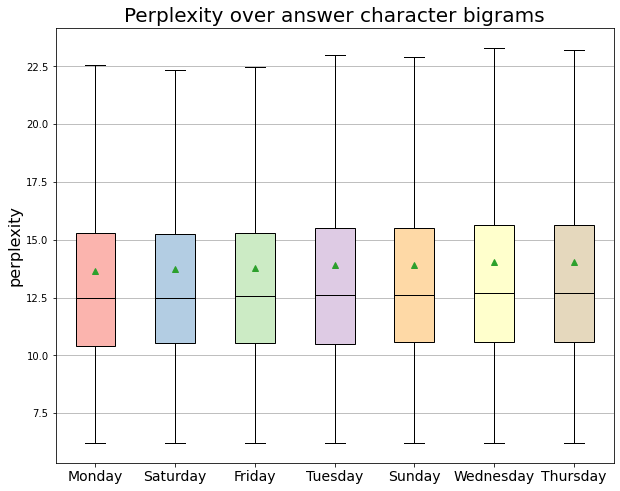

In [47]:
# plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
bplot = ax.boxplot(perplex_data['list'],patch_artist=True, medianprops=dict(color='black'), showfliers=False, showmeans=True)
ax.set_xticklabels(perplex_data['Weekday'].tolist(),fontsize=14)
ax.set_ylabel('perplexity',fontsize=16)
ax.set_title('Perplexity over answer character bigrams',fontsize=20)
ax.grid(True,axis='y')

cmap = cm.get_cmap('Pastel1')

for patch, color in zip(bplot['boxes'], cmap.colors):
    patch.set_facecolor(color)
#plt.savefig(fname="density")
plt.show()

In [49]:
df_perplex.groupby('Answer')['AnsPerplexity'].max().sort_values().reset_index().head(10)

,Answer,AnsPerplexity
0,ARE,6.210951
1,ARES,6.232525
2,ALES,6.428944
3,ALE,6.456581
4,STES,6.469651
5,STERES,6.502881
6,STE,6.507724
7,STERE,6.533946
8,ANES,6.576904
9,ANE,6.642858


In [50]:
df_perplex.groupby('Answer')['AnsPerplexity'].max().sort_values(ascending=False).reset_index().head(10)

,Answer,AnsPerplexity
0,ZXCVBNM,397.876266
1,UUUUU,350.986030
2,QQQQ,349.571566
3,HXHHXHHXHHXHHXH,349.198234
4,QE2,337.669573
5,BXQ,323.884964
6,7BC,245.141095
7,9PM,244.868480
8,3DTV,201.825916
9,1LB,198.487228


In [51]:
df_perplex.groupby('Answer')['AnsPerplexity'].max().sort_values(ascending=False).reset_index().head(10)

,Answer,AnsPerplexity
0,ZXCVBNM,397.876266
1,UUUUU,350.986030
2,QQQQ,349.571566
3,HXHHXHHXHHXHHXH,349.198234
4,QE2,337.669573
5,BXQ,323.884964
6,7BC,245.141095
7,9PM,244.868480
8,3DTV,201.825916
9,1LB,198.487228


In [52]:
Q1 = df_perplex['AnsPerplexity'].quantile(0.25)
Q3 = df_perplex['AnsPerplexity'].quantile(0.75)
IQR = Q3 - Q1
cutoff = Q3 + 1.5 * IQR
print(cutoff)

df_perplex[['AnsPerplexity']].loc[df_perplex['AnsPerplexity'] > cutoff]

22.85733941208343


,AnsPerplexity
0,37.688248
39,25.173166
50,23.365316
103,23.426173
131,88.501562
...,...
801761,28.450719
801770,50.061415
801787,23.199731
801789,24.596258


In [53]:
df_perplex['PerplexityOutlier'] = df_perplex['AnsPerplexity'].apply(lambda x: True if x > cutoff else False)

In [54]:
df_perplex.groupby('Weekday')['PerplexityOutlier'].count().sort_values().reset_index()

,Weekday,PerplexityOutlier
0,Saturday,93105
1,Friday,96557
2,Thursday,102272
3,Wednesday,105553
4,Tuesday,105965
5,Monday,106512
6,Sunday,191916


In [55]:
df_perplex.loc[df_perplex['Date'] == '1994-01-02'][['PerplexityOutlier']].value_counts()

PerplexityOutlier
False                162
True                   8
dtype: int64

In [56]:
df_perplex.columns

Index(['Year', 'Month', 'Day', 'Weekday', 'Direction', 'Line', 'Hint',
       'Answer', 'Author', 'Editor', 'PuzTitle', 'PuzClue', 'NumRows',
       'NumCols', 'NumWords', 'NumBlocks', 'MissingLetters', 'BlockDensity',
       'AnswerLength', 'Date', 'OtherPuzAns', 'AnsPerplexity', 'AnsEntropy',
       'PerplexityOutlier'],
      dtype='object')

In [57]:
perplex_pcts = df_perplex.groupby(['Date','Weekday']).agg({'PerplexityOutlier' : 'sum', 'NumWords' : "max"}).reset_index().copy()

perplex_pcts['PctPerplex'] = perplex_pcts['PerplexityOutlier'] / perplex_pcts['NumWords'] * 100

perplex_pct_data = perplex_pcts.groupby('Weekday')['PctPerplex'].agg([np.mean, list]).reset_index().sort_values('mean').copy()

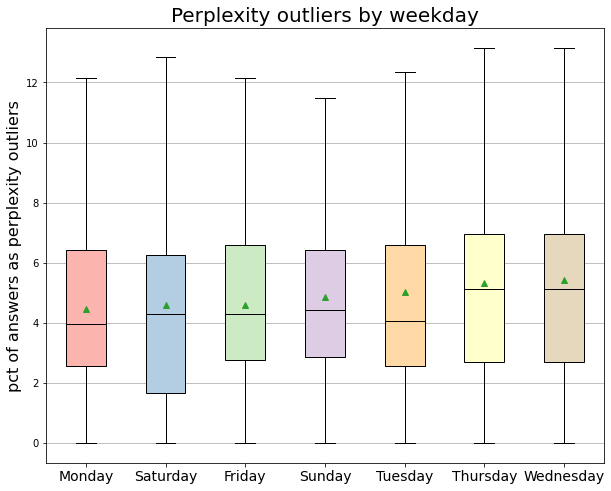

In [58]:
# plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
bplot = ax.boxplot(perplex_pct_data['list'],patch_artist=True, medianprops=dict(color='black'), showfliers=False, showmeans=True)
ax.set_xticklabels(perplex_pct_data['Weekday'].tolist(),fontsize=14)
ax.set_ylabel('pct of answers as perplexity outliers',fontsize=16)
ax.set_title('Perplexity outliers by weekday',fontsize=20)
ax.grid(True,axis='y')

cmap = cm.get_cmap('Pastel1')

for patch, color in zip(bplot['boxes'], cmap.colors):
    patch.set_facecolor(color)
#plt.savefig(fname="density")
plt.show()

In [59]:
#Make a column for answer length
df_perplex['AnswerLength'] = df_perplex['Answer'].str.len()

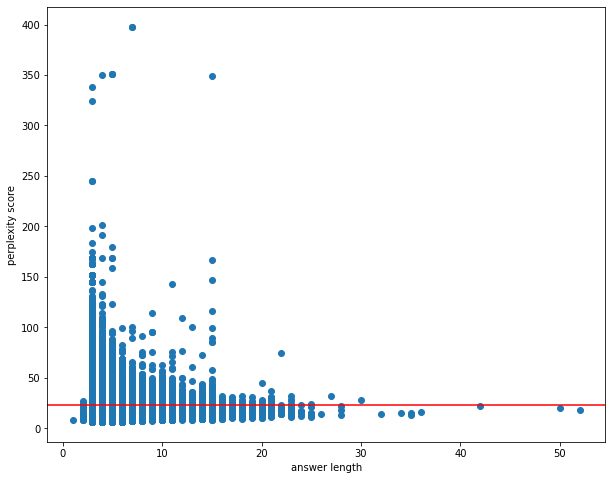

In [60]:
plt.figure(figsize=(10,8))
plt.scatter(df_perplex['AnswerLength'],df_perplex['AnsPerplexity'])
plt.axhline(y=cutoff, color='r')
plt.ylabel("perplexity score")
plt.xlabel("answer length")

plt.show()

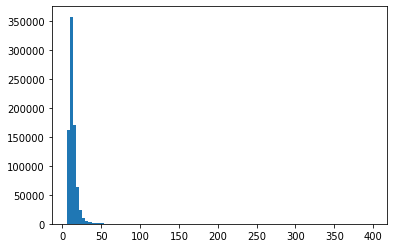

In [61]:
plt.hist(df_perplex['AnsPerplexity'],bins=100)

plt.show()



## df for classifiers

- puzzle density
- answer length
- answer rarity

In [ ]:
df.columns

In [ ]:
df_dict = {'OtherPuzAns' : sum, 'AnswerLength' : np.mean}

# build new df with selected columns and calculations
df_features = df.groupby(['Date','Weekday','BlockDensity']).agg(df_dict).reset_index().copy()

In [ ]:
# add a column with numerical day of week
df_features['WeekdayNum'] = df_features['Date'].apply(lambda x: x.day_of_week)

In [ ]:
# export as csv for model trainint
#df_features.to_csv('nick_df_features.csv')